In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install rasterio geopandas shapely osmnx matplotlib descartes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 3.6 MB/s eta 0:00:00


In [ ]:
# @title Packages
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from rasterio.warp import transform_bounds
import matplotlib.patches as mpatches
import osmnx as ox
import geopandas as gpd
from rasterio.features import geometry_mask
from scipy import ndimage
from math import radians, sin, cos, sqrt, atan2

In [ ]:
# @title Reading on Bands
# --- 1. Folderi me bandat ---
bands_folder = "/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Bands"

# --- 2. Lista e muajve dhe file-ve për B4 dhe B8 ---
months = [
    "September", "October", "November", "December",
    "January", "February", "March", "April",
    "May", "June", "July", "August"
]

# --- 3. Inicializo dictionary për B4 dhe B8 ---
B4 = {}
B8 = {}

# --- 4. Lexo file-t për çdo muaj ---
for month in months:
    # Gjej file-t për muajin
    files = os.listdir(bands_folder)

    # Filtrim B4 dhe B8
    B4_files = sorted([f for f in files if f.startswith("B4") and month in f])
    B8_files = sorted([f for f in files if f.startswith("B8") and month in f])

    # Lexo rasterat dhe bëj mesataren nëse ka dy file (p.sh. June)
    B4_stack = []
    B8_stack = []

    for f in B4_files:
        path = os.path.join(bands_folder, f)
        with rasterio.open(path) as src:
            B4_stack.append(src.read(1).astype(float))

    for f in B8_files:
        path = os.path.join(bands_folder, f)
        with rasterio.open(path) as src:
            B8_stack.append(src.read(1).astype(float))

    # Mesatarja në rast se ka më shumë se një file
    B4[month] = np.mean(B4_stack, axis=0)
    B8[month] = np.mean(B8_stack, axis=0)

print("Të gjitha bandat B4 dhe B8 janë lexuar dhe mesataruar për qershor nëse ka dy data.")

Të gjitha bandat B4 dhe B8 janë lexuar dhe mesataruar për qershor nëse ka dy data.


In [ ]:
# @title 3D NDVI Shape
# --- 1. Inicializo dictionary për NDVI ---
NDVI = {}

# --- 2. Llogarit NDVI për çdo muaj ---
for month in months:
    ndvi = (B8[month] - B4[month]) / (B8[month] + B4[month])
    NDVI[month] = ndvi

print("NDVI e të gjithë muajve u llogarit.")

# --- 3. Ndërto kubin 3D NDVI ---
# Rreshtojmë muajt sipas kronologjisë
ndvi_stack = np.stack([NDVI[m] for m in months], axis=0)  # shape: (12, height, width)

print("Kub 3D NDVI u krijua me shape:", ndvi_stack.shape)


/tmp/ipython-input-903306853.py:7: RuntimeWarning: invalid value encountered in divide
  ndvi = (B8[month] - B4[month]) / (B8[month] + B4[month])


NDVI e të gjithë muajve u llogarit.
Kub 3D NDVI u krijua me shape: (12, 1334, 1191)


/tmp/ipython-input-3552761944.py:13: RuntimeWarning: All-NaN slice encountered
  ndvi_min = np.nanmin(ndvi_stack, axis=0)
/tmp/ipython-input-3552761944.py:14: RuntimeWarning: All-NaN slice encountered
  ndvi_max = np.nanmax(ndvi_stack, axis=0)


Real pixel area: 54.17 m²
Seasonal NDVI variation calculated.


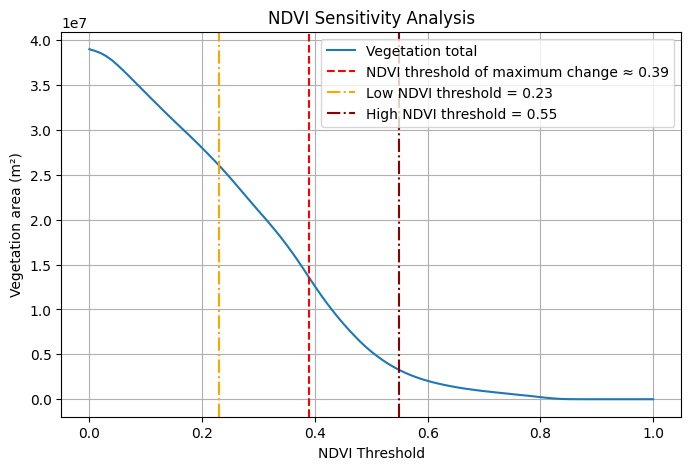

In [ ]:
# @title Threshold
# --- 0. Get real pixel_area from raster ---
sample_file = os.path.join(bands_folder, "B4_September.tiff")  # make sure correct path
with rasterio.open(sample_file) as src:
    transform = src.transform
    pixel_width = transform.a
    pixel_height = abs(transform.e)
    pixel_area = pixel_width * pixel_height  # real pixel area (m²)

print(f"Real pixel area: {pixel_area:.2f} m²")

# --- 1. Calculate seasonal NDVI variation ---
ndvi_min = np.nanmin(ndvi_stack, axis=0)
ndvi_max = np.nanmax(ndvi_stack, axis=0)
ndvi_range = ndvi_max - ndvi_min

print("Seasonal NDVI variation calculated.")

# --- 2. Sensitivity study with thresholds from 0 to 1 ---
thresholds = np.linspace(0, 1, 101)  # 0, 0.01, ..., 1
veg_areas = []

for t in thresholds:
    veg_mask = np.nanmean(ndvi_stack > t, axis=0) > 0.5
    veg_area_m2 = np.sum(veg_mask) * pixel_area
    veg_areas.append(veg_area_m2)

veg_areas = np.array(veg_areas)

# --- 3. Numerical derivative and maximum change point ---
d_veg = np.gradient(veg_areas, thresholds)
max_change_idx = np.argmax(-d_veg)
threshold_change = thresholds[max_change_idx]

# --- 4. Visualization: NDVI Sensitivity with three reference lines ---
plt.figure(figsize=(8,5))
plt.plot(thresholds, veg_areas, label="Vegetation total")

# Main line for maximum change point (~0.39)
plt.axvline(threshold_change, color='red', linestyle='--',
            label=f'NDVI threshold of maximum change ≈ {threshold_change:.2f}')

# Modified line for Low NDVI threshold (0.23 instead of 0.22)
plt.axvline(0.23, color='orange', linestyle='-.',
            label='Low NDVI threshold = 0.23')

# Line for High NDVI threshold (0.55)
plt.axvline(0.55, color='darkred', linestyle='-.',
            label='High NDVI threshold = 0.55')

plt.xlabel("NDVI Threshold")
plt.ylabel("Vegetation area (m²)")
plt.title("NDVI Sensitivity Analysis")
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipython-input-4135829652.py:49: RuntimeWarning: invalid value encountered in divide
  ndvi = (B8[month] - B4[month]) / (B8[month] + B4[month])


All B4 and B8 bands read and averaged.


/tmp/ipython-input-4135829652.py:56: RuntimeWarning: All-NaN slice encountered
  ndvi_min = np.nanmin(ndvi_stack, axis=0)
/tmp/ipython-input-4135829652.py:57: RuntimeWarning: All-NaN slice encountered
  ndvi_max = np.nanmax(ndvi_stack, axis=0)


Phenology raster saved: /content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.39/phenology_classification_039_threshold.tif


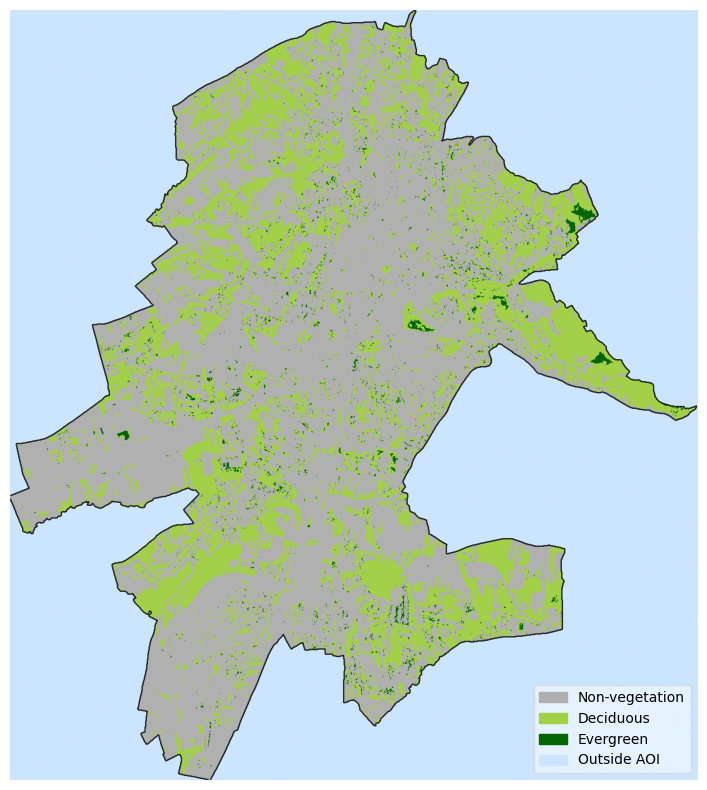

In [ ]:
# @title phenology_classification
# --------------------------
# 0. Parameters
# --------------------------
bands_folder = "/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Bands"
months_order = ["September","October","November","December","January","February","March","April","May","June","July","August"]
# --------------------------
# 0a. Get real pixel_area from raster
# --------------------------

sample_file = os.path.join(bands_folder, "B4_September.tiff")
with rasterio.open(sample_file) as src:
    transform = src.transform
    pixel_width = transform.a
    pixel_height = abs(transform.e)
    pixel_area = pixel_width * pixel_height  # real pixel area (e.g., about 54 m²)
veg_threshold = 0.39       # CHANGED: fixed threshold 0.39 for vegetation
seasonal_threshold = 0.25   # threshold for deciduous vs evergreen

# --------------------------
# 1. Read and average B4 and B8 bands
# --------------------------
B4 = {}
B8 = {}

for month in months_order:
    B4_stack = []
    B8_stack = []

    for file in os.listdir(bands_folder):
        if f"B4_{month}" in file:
            with rasterio.open(os.path.join(bands_folder, file)) as src:
                B4_stack.append(src.read(1).astype(float))
        elif f"B8_{month}" in file:
            with rasterio.open(os.path.join(bands_folder, file)) as src:
                B8_stack.append(src.read(1).astype(float))

    # Average if there are multiple files per month
    B4[month] = np.mean(B4_stack, axis=0)
    B8[month] = np.mean(B8_stack, axis=0)

print("All B4 and B8 bands read and averaged.")

# --------------------------
# 2. Calculate NDVI for each month
# --------------------------
ndvi_stack = []
for month in months_order:
    ndvi = (B8[month] - B4[month]) / (B8[month] + B4[month])
    ndvi_stack.append(ndvi)
ndvi_stack = np.stack(ndvi_stack, axis=0)  # shape: (12, height, width)

# --------------------------
# 3. Calculate seasonal variation
# --------------------------
ndvi_min = np.nanmin(ndvi_stack, axis=0)
ndvi_max = np.nanmax(ndvi_stack, axis=0)
ndvi_range = ndvi_max - ndvi_min

# --------------------------
# 4. Vegetation mask
# --------------------------
veg_mask_mean = np.nanmean(ndvi_stack > veg_threshold, axis=0) > 0.5

# --------------------------
# 5. Deciduous / evergreen classification
# --------------------------
phenology_class = np.zeros_like(ndvi_range, dtype=np.uint8)  # 0 = non-vegetation
phenology_class[veg_mask_mean] = np.where(ndvi_range[veg_mask_mean] > seasonal_threshold, 1, 2)
# 1 = deciduous, 2 = evergreen
#################
# --------------------------
# 5a. Prepare visualization with areas outside AOI
# --------------------------
# Create AOI mask (where there is data)
aoi_mask = ~np.isnan(ndvi_stack[0])  # or mask showing the data area

# Copy existing raster
phenology_vis = phenology_class.copy()

# Area outside AOI = value 3
phenology_vis[~aoi_mask] = 3

# Colors: 0=gray, 1=light green, 2=dark green, 3=very light blue
colors = ["#B0B0B0", "#A2D149", "#006400", "#CCE5FF"]  # add blue for outside AOI
cmap = ListedColormap(colors)
################################

# --------------------------
# 6. Save final raster as TIFF for QGIS
# --------------------------
out_path = "/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.39/phenology_classification_039_threshold.tif"
sample_file = os.path.join(bands_folder, "B4_September.tiff")

with rasterio.open(sample_file) as src:
    profile = src.profile

profile.update(
    dtype=rasterio.uint8,
    count=1,
    nodata=0,
    compress='lzw',
    description="Phenology raster: 0=non-vegetation, 1=deciduous, 2=evergreen"
)

with rasterio.open(out_path, "w", **profile) as dst:
    dst.write(phenology_class, 1)

print("Phenology raster saved:", out_path)

# --------------------------
plt.figure(figsize=(10,10))
plt.imshow(phenology_vis, cmap=cmap)
plt.axis('off')

# Contour for AOI boundary
plt.contour(aoi_mask, levels=[0.5], colors='black', linewidths=1, alpha=0.8)

patches = [
    mpatches.Patch(color=colors[0], label='Non-vegetation'),
    mpatches.Patch(color=colors[1], label='Deciduous'),
    mpatches.Patch(color=colors[2], label='Evergreen'),
    mpatches.Patch(color=colors[3], label='Outside AOI')
]
plt.legend(handles=patches, loc='lower right', framealpha=0.5)
plt.show()

In [ ]:
# @title Vegetation Statistics
# --------------------------
# 8. Calculate areas (improved version with pixel-area and boundaries)
# --------------------------

# Read the area of interest boundary
border_file = "/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Border/Border_Urban_Pristina.geojson"
study_area = gpd.read_file(border_file)

# Open raster to get transform and CRS
with rasterio.open(sample_file) as src:
    transform = src.transform
    raster_crs = src.crs
    pixel_width = transform.a
    pixel_height = abs(transform.e)
    pixel_area = pixel_width * pixel_height

# Convert shapefile to same CRS as raster
study_area = study_area.to_crs(raster_crs)

# Create mask within the boundary
with rasterio.open(sample_file) as src:
    mask = geometry_mask([geom for geom in study_area.geometry],
                         transform=src.transform,
                         invert=True,
                         out_shape=(src.height, src.width))

# Calculate areas only within mask
def calc_area(mask, pixel_area):
    pixels = np.count_nonzero(mask)
    area_m2 = pixels * pixel_area
    return pixels, area_m2

total_pixels = mask.sum()
veg_pixels, veg_area = calc_area(veg_mask_mean & mask, pixel_area)
nonveg_pixels, nonveg_area = total_pixels - veg_pixels, (total_pixels - veg_pixels) * pixel_area
deciduous_pixels, deciduous_area = calc_area((phenology_class == 1) & mask, pixel_area)
evergreen_pixels, evergreen_area = calc_area((phenology_class == 2) & mask, pixel_area)

def perc(part, whole):
    return (part / whole * 100) if whole != 0 else 0

print("=== Vegetation Statistics (within boundary) - Threshold 0.39 ===")
print(f"Total area: {total_pixels * pixel_area:.2f} m²")
print(f"Vegetation area: {veg_area:.2f} m² ({perc(veg_pixels, total_pixels):.2f}%)")
print(f"Non-vegetation area: {nonveg_area:.2f} m² ({perc(nonveg_pixels, total_pixels):.2f}%)")
print(f"Deciduous area: {deciduous_area:.2f} m² ({perc(deciduous_pixels, veg_pixels):.2f}% of vegetation)")
print(f"Evergreen area: {evergreen_area:.2f} m² ({perc(evergreen_pixels, veg_pixels):.2f}% of vegetation)")

# --------------------------
# 9. Extract study area coordinates (supporting MultiPolygon)
# --------------------------
from shapely.geometry import Polygon, MultiPolygon

# Convert polygon to lat/lon (EPSG:4326) for printing
study_area_ll = study_area.to_crs('EPSG:4326')

for i, geom in enumerate(study_area_ll.geometry):
    # Polygon centroid (or MultiPolygon)
    centroid = geom.centroid
    print(f"Polygon {i} centroid: Latitude={centroid.y:.6f}, Longitude={centroid.x:.6f}")

    # Boundary coordinates
    if isinstance(geom, Polygon):
        coords = list(geom.exterior.coords)
        print(f"Polygon {i} boundary coordinates (first 5 points): {coords[:5]} ...")
    elif isinstance(geom, MultiPolygon):
        for j, poly in enumerate(geom.geoms):
            coords = list(poly.exterior.coords)
            print(f"Polygon {i}, part {j} boundary coordinates (first 5 points): {coords[:5]} ...")

# --------------------------
# 10. Save statistics to CSV file for threshold 0.39
# --------------------------
import pandas as pd
import os

# Create directory if it doesn't exist
output_dir = "/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.39"
os.makedirs(output_dir, exist_ok=True)

stats_data = {
    'Threshold': [0.39],
    'Total_Area_m2': [total_pixels * pixel_area],
    'Vegetation_Area_m2': [veg_area],
    'Vegetation_Percentage': [perc(veg_pixels, total_pixels)],
    'NonVegetation_Area_m2': [nonveg_area],
    'NonVegetation_Percentage': [perc(nonveg_pixels, total_pixels)],
    'Deciduous_Area_m2': [deciduous_area],
    'Deciduous_Percentage': [perc(deciduous_pixels, veg_pixels)],
    'Evergreen_Area_m2': [evergreen_area],
    'Evergreen_Percentage': [perc(evergreen_pixels, veg_pixels)]
}

stats_df = pd.DataFrame(stats_data)
csv_path = "/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.39/vegetation_statistics_039.csv"
stats_df.to_csv(csv_path, index=False)
print(f"\nStatistics saved to: {csv_path}")

=== Vegetation Statistics (within boundary) - Threshold 0.39 ===
Total area: 39431468.56 m²
Vegetation area: 13455831.13 m² (34.12%)
Non-vegetation area: 25975637.43 m² (65.88%)
Deciduous area: 12882232.86 m² (95.74% of vegetation)
Evergreen area: 573598.28 m² (4.26% of vegetation)
Polygon 0 centroid: Latitude=42.654434, Longitude=21.154985
Polygon 0, part 0 boundary coordinates (first 5 points): [(21.1195995, 42.66094089999999), (21.1197225, 42.6605663), (21.1198402, 42.66024399999999), (21.1198999, 42.66009110000001), (21.1199655, 42.65991149999999)] ...

Statistics saved to: /content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.39/vegetation_statistics_039.csv



🏞️ GREEN SPACES SIZE CLASSIFICATION
🌳 Found 3714 individual green spaces


✅ Sizes raster saved: /content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.39/green_space_sizes_039_2kmin.tif

📊 GREEN SPACES BY SIZE (≥2000m²): 482 spaces
   0 - Minimal Vegetation (<2000 m²): 21,763 pixels, 1,178,997 m² (3.0%)
   1 - Small (2,000-20,000 m²): 40,801 pixels, 2,210,369 m² (18.0%)
   2 - Medium (20,000-100,000 m²): 46,478 pixels, 2,517,917 m² (20.5%)
   3 - Large (>100,000 m²): 139,338 pixels, 7,548,549 m² (61.5%)
🌳 TOTAL TRUE GREEN SPACES AREA (≥2000m²): 12,276,834 m²
📐 This represents 31.1% of the total study area (39,431,469 m²)


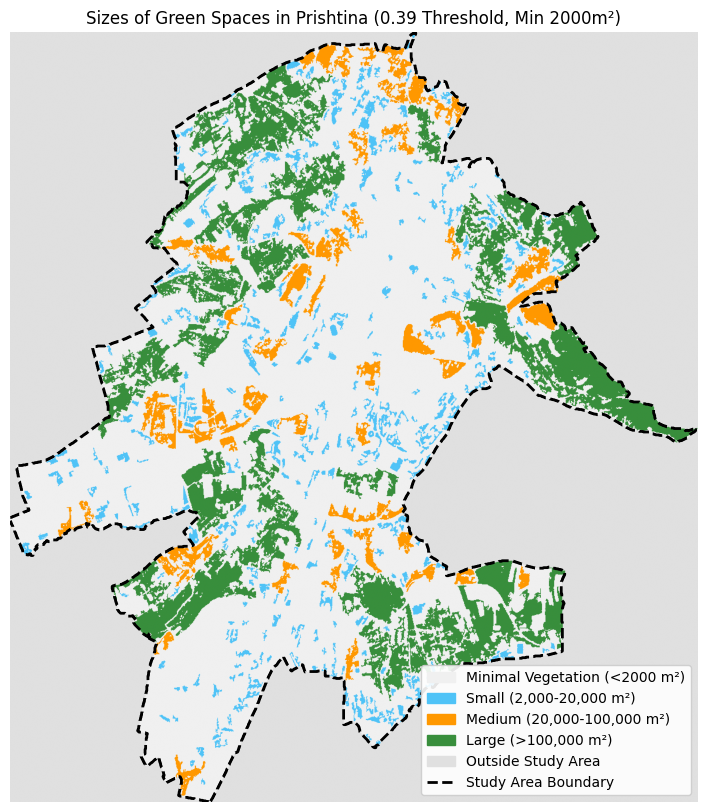


💾 SAVING GREEN SPACES SIZE RASTER
✅ Sizes raster saved: /content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.39/green_space_sizes_039_2kmin.tif
📊 Format: TIFF
🎯 Categories: 0-3 (4 different categories)
🔍 Verification: Shape = (1334, 1191), Unique values = [0 1 2 3]
📊 Green spaces statistics saved to: /content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.39/green_spaces_statistics_039.csv


In [ ]:
# @title Green Spaces Classification in Pristina
# --------------------------
# 10. GREEN SPACES SIZE CLASSIFICATION
# --------------------------
print("\n🏞️ GREEN SPACES SIZE CLASSIFICATION")

# Identify individual vegetation spaces (1 + 2)
vegetation_mask = (phenology_class == 1) | (phenology_class == 2)
structure = np.ones((3, 3), dtype=bool)
labeled_array, num_features = ndimage.label(vegetation_mask, structure=structure)

# Create sizes raster
green_space_sizes = np.zeros_like(phenology_class, dtype=np.uint8)

print(f"🌳 Found {num_features} individual green spaces")

large_green_count = 0
for i in range(1, num_features + 1):
    pixels = np.where(labeled_array == i)
    area_pixels = len(pixels[0])
    area_m2 = area_pixels * pixel_area

    # MINIMUM AREA FILTER: Skip areas smaller than 2000 m²
    if area_m2 < 2000:
        continue  # Skip very small areas

    # NEW SIZE CATEGORIES - ONLY 3 CLASSES
    if area_m2 >= 2000 and area_m2 < 20000:
        size_class = 1  # Small Green Space (2,000-20,000 m²)
        large_green_count += 1
    elif area_m2 >= 20000 and area_m2 < 100000:
        size_class = 2  # Medium Green Space (20,000-100,000 m²)
        large_green_count += 1
    elif area_m2 >= 100000:
        size_class = 3  # Large Green Space (>100,000 m²)
        large_green_count += 1
    else:
        size_class = 0  # This shouldn't happen with the filter above

    green_space_sizes[pixels] = size_class

# Save sizes raster
sizes_output_path = "/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.39/green_space_sizes_039_2kmin.tif"

with rasterio.open(sample_file) as src:
    sizes_profile = src.profile

sizes_profile.update(
    dtype=rasterio.uint8,
    count=1,
    nodata=0,
    compress='lzw',
    description="Green space sizes with 0.39 threshold, min 2000m²: 1=Small (2k-20k m²), 2=Medium (20k-100k m²), 3=Large (>100k m²)"
)

with rasterio.open(sizes_output_path, "w", **sizes_profile) as dst:
    dst.write(green_space_sizes, 1)

print("✅ Sizes raster saved:", sizes_output_path)

# Size statistics - CORRECTED CALCULATION
print(f"\n📊 GREEN SPACES BY SIZE (≥2000m²): {large_green_count} spaces")

size_categories = {
    0: "Minimal Vegetation (<2000 m²)",
    1: "Small (2,000-20,000 m²)",
    2: "Medium (20,000-100,000 m²)",
    3: "Large (>100,000 m²)"
}

# CORRECTED: Calculate total pixels for percentage calculation
total_green_space_pixels = np.sum((green_space_sizes >= 1) & (green_space_sizes <= 3) & mask)
total_study_area_pixels = np.sum(mask)

total_true_green_area = 0
for size_class, label in size_categories.items():
    if size_class == 0:
        # For minimal vegetation, count all vegetation pixels that are NOT in classes 1,2,3
        veg_pixels_minimal = np.sum(vegetation_mask & mask) - total_green_space_pixels
        area_m2 = veg_pixels_minimal * pixel_area
        percentage = (veg_pixels_minimal / total_study_area_pixels * 100) if total_study_area_pixels > 0 else 0
    else:
        # For actual green spaces (classes 1,2,3)
        pixels_in_class = np.sum((green_space_sizes == size_class) & mask)
        area_m2 = pixels_in_class * pixel_area
        total_true_green_area += area_m2
        percentage = (pixels_in_class / total_green_space_pixels * 100) if total_green_space_pixels > 0 else 0

    if area_m2 > 0:
        print(f"   {size_class} - {label}: {pixels_in_class if size_class > 0 else veg_pixels_minimal:>6,} pixels, {area_m2:>8,.0f} m² ({percentage:.1f}%)")

# CORRECTED: Calculate percentages relative to total study area
total_study_area_m2 = total_study_area_pixels * pixel_area
green_space_percentage = (total_true_green_area / total_study_area_m2 * 100) if total_study_area_m2 > 0 else 0

print(f"🌳 TOTAL TRUE GREEN SPACES AREA (≥2000m²): {total_true_green_area:,.0f} m²")
print(f"📐 This represents {green_space_percentage:.1f}% of the total study area ({total_study_area_m2:,.0f} m²)")

# --------------------------
# 11. VISUALIZATION OF GREEN SPACES SIZES WITH AOI BOUNDARY
# --------------------------
plt.figure(figsize=(12, 10))

# Colors for 4 categories
size_colors = ["#F0F0F0", "#4FC3F7", "#FF9800", "#388E3C"]
size_cmap = ListedColormap(size_colors)

# Create visual version that includes area outside AOI
size_vis_with_aoi = green_space_sizes.copy().astype(float)

# Set special value for area outside AOI
size_vis_with_aoi[~aoi_mask] = 4  # New value for outside AOI

# Create extended colormap for 5 values (4 categories + outside AOI)
extended_colors = size_colors + ["#E0E0E0"]  # Add gray for outside AOI
extended_cmap = ListedColormap(extended_colors)

# Visualize
plt.imshow(size_vis_with_aoi, cmap=extended_cmap, vmin=0, vmax=4)
plt.axis('off')

# Draw AOI boundary with black line
plt.contour(aoi_mask, levels=[0.5], colors='black', linewidths=2, linestyles='--')

# Extended legend
size_patches = [
    mpatches.Patch(color=extended_colors[0], label='Minimal Vegetation (<2000 m²)'),
    mpatches.Patch(color=extended_colors[1], label='Small (2,000-20,000 m²)'),
    mpatches.Patch(color=extended_colors[2], label='Medium (20,000-100,000 m²)'),
    mpatches.Patch(color=extended_colors[3], label='Large (>100,000 m²)'),
    mpatches.Patch(color=extended_colors[4], label='Outside Study Area'),
    plt.Line2D([0], [0], color='black', linewidth=2, linestyle='--', label='Study Area Boundary')
]

plt.legend(handles=size_patches, loc='lower right', framealpha=0.9)
plt.title('Sizes of Green Spaces in Prishtina (0.39 Threshold, Min 2000m²)')
plt.show()

# --------------------------
# 12. SAVING GREEN SPACES SIZE RASTER
# --------------------------
print("\n💾 SAVING GREEN SPACES SIZE RASTER")

# Define output path
sizes_output_path = "/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.39/green_space_sizes_039_2kmin.tif"

# Get profile from original raster
with rasterio.open(sample_file) as src:
    sizes_profile = src.profile

# Update profile for new raster
sizes_profile.update(
    dtype=rasterio.uint8,
    count=1,
    nodata=0,
    compress='lzw',
    description="Green space sizes with 0.39 threshold, min 2000m²: 1=Small (2k-20k m²), 2=Medium (20k-100k m²), 3=Large (>100k m²)"
)

# Save raster
with rasterio.open(sizes_output_path, "w", **sizes_profile) as dst:
    dst.write(green_space_sizes, 1)

print("✅ Sizes raster saved:", sizes_output_path)
print("📊 Format: TIFF")
print("🎯 Categories: 0-3 (4 different categories)")

# Quick verification
with rasterio.open(sizes_output_path) as src:
    saved_data = src.read(1)
    print(f"🔍 Verification: Shape = {saved_data.shape}, Unique values = {np.unique(saved_data)}")

# --------------------------
# 13. SAVE GREEN SPACES STATISTICS TO CSV
# --------------------------
import pandas as pd

# Create statistics dataframe
green_stats_data = {
    'Threshold': [0.39],
    'Total_Green_Spaces_Count': [large_green_count],
    'Total_Green_Area_m2': [total_true_green_area],
    'Green_Area_Percentage': [green_space_percentage],
    'Small_Spaces_Count': [np.sum((green_space_sizes == 1) & mask)],
    'Small_Spaces_Area_m2': [np.sum((green_space_sizes == 1) & mask) * pixel_area],
    'Medium_Spaces_Count': [np.sum((green_space_sizes == 2) & mask)],
    'Medium_Spaces_Area_m2': [np.sum((green_space_sizes == 2) & mask) * pixel_area],
    'Large_Spaces_Count': [np.sum((green_space_sizes == 3) & mask)],
    'Large_Spaces_Area_m2': [np.sum((green_space_sizes == 3) & mask) * pixel_area],
    'Minimal_Vegetation_Area_m2': [np.sum(vegetation_mask & mask) - total_green_space_pixels * pixel_area]
}

green_stats_df = pd.DataFrame(green_stats_data)
green_stats_csv_path = "/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.39/green_spaces_statistics_039.csv"
green_stats_df.to_csv(green_stats_csv_path, index=False)
print(f"📊 Green spaces statistics saved to: {green_stats_csv_path}")

In [ ]:
# @title COMPLETE ANALYSIS + TABLE - Green Spaces with Gender & Age (Threshold 0.39) - 2024
# --------------------------
# SINGLE CELL: COMPLETE ANALYSIS AND TABLE FOR GREEN SPACES
# --------------------------

import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import geometry_mask
from scipy import ndimage
import os
from shapely.geometry import Polygon, MultiPolygon
import pandas as pd

print("🔥 COMPLETE ANALYSIS OF GREEN SPACES WITH GENDER AND AGE (THRESHOLD 0.39) - 2024")
print("=" * 100)

# --------------------------
# 1. PATHS AND CONFIGURATION - UPDATED FOR 2024
# --------------------------
print("📍 Setting up paths and configuration...")

# PATHS FOR 2024 - THRESHOLD 0.39
sizes_path = "/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.39/green_space_sizes_039_2kmin.tif"
pop_base_path = "/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Pop_7m"
border_path = "/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Border/Border_Urban_Pristina.geojson"
phenology_path = "/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.39/phenology_classification_039_threshold.tif"

# Green Spaces categories (3 CLASSES)
green_space_categories = {
    1: "Small (2,000-20,000 m²)",
    2: "Medium (20,000-100,000 m²)",
    3: "Large (>100,000 m²)"
}

# All population files - UPDATED FOR 2024 + ADDED TOTAL POPULATION
pop_files = {
    'pop_total': "xkx_pop_2024_CN_7m_R2025A_v1_.tif",  # ADDED: TOTAL POPULATION
    'femra_total': "xkx_T_F_2024_CN_7m_R2025A_v1.tif",
    'meshkuj_total': "xkx_T_M_2024_CN_7m_R2025A_v1.tif",
    'f_00': "xkx_f_00_2024_CN_7m_R2025A_v1.tif", 'f_01': "xkx_f_01_2024_CN_7m_R2025A_v1.tif",
    'f_05': "xkx_f_05_2024_CN_7m_R2025A_v1.tif", 'f_10': "xkx_f_10_2024_CN_7m_R2025A_v1.tif",
    'f_15': "xkx_f_15_2024_CN_7m_R2025A_v1.tif", 'f_20': "xkx_f_20_2024_CN_7m_R2025A_v1.tif",
    'f_25': "xkx_f_25_2024_CN_7m_R2025A_v1.tif", 'f_30': "xkx_f_30_2024_CN_7m_R2025A_v1.tif",
    'f_35': "xkx_f_35_2024_CN_7m_R2025A_v1.tif", 'f_40': "xkx_f_40_2024_CN_7m_R2025A_v1.tif",
    'f_45': "xkx_f_45_2024_CN_7m_R2025A_v1.tif", 'f_50': "xkx_f_50_2024_CN_7m_R2025A_v1.tif",
    'f_55': "xkx_f_55_2024_CN_7m_R2025A_v1.tif", 'f_60': "xkx_f_60_2024_CN_7m_R2025A_v1.tif",
    'f_65': "xkx_f_65_2024_CN_7m_R2025A_v1.tif", 'f_70': "xkx_f_70_2024_CN_7m_R2025A_v1.tif",
    'f_75': "xkx_f_75_2024_CN_7m_R2025A_v1.tif", 'f_80': "xkx_f_80_2024_CN_7m_R2025A_v1.tif",
    'f_85': "xkx_f_85_2024_CN_7m_R2025A_v1.tif", 'f_90': "xkx_f_90_2024_CN_7m_R2025A_v1.tif",
    'm_00': "xkx_m_00_2024_CN_7m_R2025A_v1.tif", 'm_01': "xkx_m_01_2024_CN_7m_R2025A_v1.tif",
    'm_05': "xkx_m_05_2024_CN_7m_R2025A_v1.tif", 'm_10': "xkx_m_10_2024_CN_7m_R2025A_v1.tif",
    'm_15': "xkx_m_15_2024_CN_7m_R2025A_v1.tif", 'm_20': "xkx_m_20_2024_CN_7m_R2025A_v1.tif",
    'm_25': "xkx_m_25_2024_CN_7m_R2025A_v1.tif", 'm_30': "xkx_m_30_2024_CN_7m_R2025A_v1.tif",
    'm_35': "xkx_m_35_2024_CN_7m_R2025A_v1.tif", 'm_40': "xkx_m_40_2024_CN_7m_R2025A_v1.tif",
    'm_45': "xkx_m_45_2024_CN_7m_R2025A_v1.tif", 'm_50': "xkx_m_50_2024_CN_7m_R2025A_v1.tif",
    'm_55': "xkx_m_55_2024_CN_7m_R2025A_v1.tif", 'm_60': "xkx_m_60_2024_CN_7m_R2025A_v1.tif",
    'm_65': "xkx_m_65_2024_CN_7m_R2025A_v1.tif", 'm_70': "xkx_m_70_2024_CN_7m_R2025A_v1.tif",
    'm_75': "xkx_m_75_2024_CN_7m_R2025A_v1.tif", 'm_80': "xkx_m_80_2024_CN_7m_R2025A_v1.tif",
    'm_85': "xkx_m_85_2024_CN_7m_R2025A_v1.tif", 'm_90': "xkx_m_90_2024_CN_7m_R2025A_v1.tif"
}

# Age groups for table
age_groups_detailed = {
    '0-14': ['f_00', 'f_01', 'f_05', 'f_10', 'm_00', 'm_01', 'm_05', 'm_10'],
    '15-24': ['f_15', 'f_20', 'm_15', 'm_20'],
    '25-64': ['f_25', 'f_30', 'f_35', 'f_40', 'f_45', 'f_50', 'f_55', 'f_60',
             'm_25', 'm_30', 'm_35', 'm_40', 'm_45', 'm_50', 'm_55', 'm_60'],
    '65+': ['f_65', 'f_70', 'f_75', 'f_80', 'f_85', 'f_90',
           'm_65', 'm_70', 'm_75', 'm_80', 'm_85', 'm_90']
}

# --------------------------
# 2. FUNCTIONS
# --------------------------
def euclidean_distance_utm(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def load_population_data(file_path):
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            return src.read(1)
    else:
        print(f"⚠️  File {file_path} not found")
        return None

def load_all_population_data():
    pop_data = {}
    for key, filename in pop_files.items():
        file_path = os.path.join(pop_base_path, filename)
        pop_data[key] = load_population_data(file_path)
        if pop_data[key] is not None:
            total_pop = np.sum(pop_data[key])
            print(f"✅ Loaded: {filename} - {total_pop:,.0f} residents")
        else:
            print(f"❌ Failed: {filename}")
    return pop_data

# --------------------------
# 3. DATA LOADING
# --------------------------
print("📍 Loading Green Spaces and population data...")
with rasterio.open(sizes_path) as src:
    green_spaces_classified = src.read(1)
    sizes_transform = src.transform

# Load phenology to distinguish minimal vegetation
with rasterio.open(phenology_path) as src:
    phenology_class = src.read(1)

# Calculate pixel size
pixel_width = sizes_transform[0]
pixel_height = abs(sizes_transform[4])
pixel_area = pixel_width * pixel_height
print(f"✅ Pixel size: {pixel_width:.2f}m × {pixel_height:.2f}m = {pixel_area:.2f} m²")

# Load urban boundary
print("📍 Loading urban boundary...")
gdf_border = gpd.read_file(border_path)
gdf_border = gdf_border.to_crs('EPSG:32634')

# --------------------------
# 3a. EXTRACT STUDY AREA COORDINATES
# --------------------------
print("📍 Extracting study area coordinates...")
study_area_ll = gdf_border.to_crs('EPSG:4326')

for i, geom in enumerate(study_area_ll.geometry):
    # Polygon centroid (or MultiPolygon)
    centroid = geom.centroid
    print(f"📍 Polygon {i} centroid: Latitude={centroid.y:.6f}, Longitude={centroid.x:.6f}")

    # Boundary coordinates
    if isinstance(geom, Polygon):
        coords = list(geom.exterior.coords)
        print(f"📍 Polygon {i} boundary coordinates (first 5 points): {coords[:5]} ...")
    elif isinstance(geom, MultiPolygon):
        for j, poly in enumerate(geom.geoms):
            coords = list(poly.exterior.coords)
            print(f"📍 Polygon {i}, part {j} boundary coordinates (first 5 points): {coords[:5]} ...")

# Create mask for urban boundary
print("📍 Creating boundary mask...")
with rasterio.open(sizes_path) as src:
    border_mask = geometry_mask(gdf_border.geometry,
                              transform=src.transform,
                              out_shape=src.shape,
                              invert=True)

print(f"✅ Mask created. Pixels within the boundary: {np.sum(border_mask):,}")

# Apply mask to Green Spaces data
green_spaces_masked = green_spaces_classified.copy()
green_spaces_masked[~border_mask] = 0
phenology_masked = phenology_class.copy()
phenology_masked[~border_mask] = 0

# Load all population data
print("📍 Loading all population data by gender and age...")
pop_data = load_all_population_data()

# Check if data loaded successfully
if pop_data['femra_total'] is None or pop_data['meshkuj_total'] is None:
    print("❌ Error: Cannot load main population data")
    exit()

# Apply boundary mask to all population data
print("📍 Applying boundary mask to all population data...")
pop_data_masked = {}
for key, data in pop_data.items():
    if data is not None:
        pop_data_masked[key] = data * border_mask
    else:
        pop_data_masked[key] = None

# --------------------------
# 4. BASIC ANALYSIS - CORRECTED
# --------------------------
print("\n📊 BASIC STATISTICS - GREEN SPACES (Threshold 0.39) - 2024")
print("-" * 50)

# Areas within boundary
total_area_m2 = np.sum(border_mask) * pixel_area
green_spaces_area_m2 = np.sum((green_spaces_masked >= 1) & border_mask) * pixel_area
non_green_spaces_area_m2 = total_area_m2 - green_spaces_area_m2

print(f"📍 Total Area: {total_area_m2:,.0f} m² ({total_area_m2/1000000:.2f} km²)")
print(f"🌿 Green Spaces Area (≥2000m²): {green_spaces_area_m2:,.0f} m² ({green_spaces_area_m2/1000000:.2f} km²)")
print(f"📊 Green Spaces %: {green_spaces_area_m2/total_area_m2*100:.1f}%")
print(f"🏢 Non-Green Spaces Area: {non_green_spaces_area_m2:,.0f} m² ({non_green_spaces_area_m2/total_area_m2*100:.1f}%)")

# ✅ CRITICAL CORRECTION: Use same methodology as 2017
pop_total_count = np.sum(pop_data_masked['pop_total'])
pop_femra_total_count = np.sum(pop_data_masked['femra_total'])
pop_meshkuj_total_count = np.sum(pop_data_masked['meshkuj_total'])

# Data verification
gender_sum = pop_femra_total_count + pop_meshkuj_total_count
difference = pop_total_count - gender_sum

print(f"\n👥 POPULATION VERIFICATION - 2024:")
print(f"📍 TOTAL Population (from pop_total): {pop_total_count:,.0f}")
print(f"♀ FEMALE Total: {pop_femra_total_count:,.0f}")
print(f"♂ MALE Total: {pop_meshkuj_total_count:,.0f}")
print(f"🔍 Gender sum: {gender_sum:,.0f}")
print(f"📊 Difference: {difference:,.0f} ({abs(difference/pop_total_count*100):.2f}%)")

# Use pop_total for accuracy (SAME AS 2017)
pop_total_count = np.sum(pop_data_masked['pop_total'])

print(f"\n👥 FINAL POPULATION COUNTS - 2024:")
print(f"♀ FEMALE: {pop_femra_total_count:,.0f} Residents ({pop_femra_total_count/pop_total_count*100:.1f}%)")
print(f"♂ MALE: {pop_meshkuj_total_count:,.0f} Residents ({pop_meshkuj_total_count/pop_total_count*100:.1f}%)")
print(f"📍 TOTAL: {pop_total_count:,.0f} Residents")

# Green Spaces per person - CORRECTED
green_spaces_per_person = green_spaces_area_m2 / pop_total_count if pop_total_count > 0 else 0
print(f"📏 Green Spaces per Person: {green_spaces_per_person:.1f} m²/person")

# --------------------------
# 5. ACCESSIBILITY ANALYSIS - CHANGED: ANALYZE ALL RESIDENTS
# --------------------------
print(f"\n🎯 ACCESSIBILITY ANALYSIS BY GENDER, AGE AND TOTAL POPULATION")
print("=" * 80)

# Identify Green Spaces centers
print(f"📍 Identifying Green Spaces...")
green_space_centers = []
for size_class in range(1, 4):  # 3 categories
    mask = (green_spaces_masked == size_class) & border_mask
    if np.any(mask):
        structure = np.ones((3, 3), dtype=bool)
        labeled_array, num_features = ndimage.label(mask, structure=structure)

        for i in range(1, num_features + 1):
            pixels = np.where(labeled_array == i)
            if len(pixels[0]) > 0:
                center_row = np.mean(pixels[0])
                center_col = np.mean(pixels[1])
                center_x, center_y = sizes_transform * (center_col, center_row)

                green_space_centers.append({
                    'id': f"{size_class}_{i}",
                    'size_class': size_class,
                    'category': green_space_categories[size_class],
                    'center_x': center_x,
                    'center_y': center_y,
                    'area_m2': len(pixels[0]) * pixel_area,
                    'pixels': pixels
                })

print(f"✅ Found {len(green_space_centers)} Green Spaces within boundary")

# Structure for storing accessibility results - ADDED pop_total
accessibility = {}
for key in pop_files.keys():
    accessibility[key] = {}
    for size_class in range(1, 4):  # 3 categories
        accessibility[key][size_class] = {
            '0-5min': 0, '5-10min': 0, '10-15min': 0, '15-20min': 0,
            '20-25min': 0, '25-30min': 0, '30+min': 0
        }

# CHANGED: Analyze ALL residents, not just those outside vegetation
print(f"📍 Analyzing accessibility for ALL {pop_total_count:,.0f} residents...")

# Analyze for each population category - INCLUDING pop_total
for key in pop_files.keys():
    if pop_data_masked[key] is not None:
        print(f"📍 Processing: {key}...")
        # CHANGED: Get ALL residents within urban boundary
        all_indices = np.where((pop_data_masked[key] > 0) & border_mask)

        for i in range(len(all_indices[0])):
            row, col = all_indices[0][i], all_indices[1][i]
            pop_count = pop_data_masked[key][row, col]

            if pop_count > 0:
                resident_x, resident_y = sizes_transform * (col, row)

                # For each Green Spaces category, find the nearest space of that category
                for size_class in range(1, 4):  # 3 categories
                    min_distance = float('inf')
                    category_spaces = [space for space in green_space_centers if space['size_class'] == size_class]

                    for space in category_spaces:
                        distance = euclidean_distance_utm(resident_x, resident_y, space['center_x'], space['center_y'])
                        if distance < min_distance:
                            min_distance = distance

                    if min_distance < float('inf'):
                        time_min = min_distance / 80  # 4.8 km/h = 80 m/min

                        # CHANGED: First interval is 0-5 min (not 1-5 min)
                        # Determine interval
                        if time_min <= 5: interval = '0-5min'
                        elif time_min <= 10: interval = '5-10min'
                        elif time_min <= 15: interval = '10-15min'
                        elif time_min <= 20: interval = '15-20min'
                        elif time_min <= 25: interval = '20-25min'
                        elif time_min <= 30: interval = '25-30min'
                        else: interval = '30+min'

                        accessibility[key][size_class][interval] += pop_count

# --------------------------
# 6. DETAILED TABLE - ADDED FOR TOTAL POPULATION
# --------------------------
print(f"\n📊 DETAILED ACCESSIBILITY TABLE BY AGE GROUPS, TOTAL POPULATION AND CATEGORIES")
print("=" * 100)

# Create detailed table
print("\n| Age Group | Green Spaces Category | 0-5 min | 5-10 min | 10-15 min | 15-20 min | 20-25 min | 25-30 min | 30+ min | Total |")
print("| --------- | --------------------- | ------- | -------- | --------- | --------- | --------- | --------- | ------- | ----- |")

# List for storing data for CSV
detailed_data_for_csv = []

# First, add data for pop_total to the table
print(f"\n| {'TOTAL':<9} | {'---':<40} | {'---':>7} | {'---':>8} | {'---':>9} | {'---':>9} | {'---':>9} | {'---':>9} | {'---':>6} | {'---':>5} |")

for size_class in range(1, 4):  # 3 categories
    times = accessibility['pop_total'][size_class]
    total = sum(times.values())

    # Save data for pop_total
    detailed_data_for_csv.append({
        'Age_Group': 'TOTAL',
        'Green_Space_Category': green_space_categories[size_class],
        'Size_Class': size_class,
        'Time_0_5_min': times['0-5min'],
        'Time_5_10_min': times['5-10min'],
        'Time_10_15_min': times['10-15min'],
        'Time_15_20_min': times['15-20min'],
        'Time_20_25_min': times['20-25min'],
        'Time_25_30_min': times['25-30min'],
        'Time_30_plus_min': times['30+min'],
        'Total': total
    })

    line = f"| {'TOTAL':<9} | {green_space_categories[size_class]:<40} | "
    for interval in ['0-5min', '5-10min', '10-15min', '15-20min', '20-25min', '25-30min', '30+min']:
        line += f"{times[interval]:>7.0f} | "
    line += f"{total:>5.0f} |"
    print(line)

print("| --------- | --------------------- | ------- | -------- | --------- | --------- | --------- | --------- | ------- | ----- |")

# Then, data for age groups (as before)
for age_group, age_keys in age_groups_detailed.items():
    for size_class in range(1, 4):  # 3 categories
        # Calculate totals for this age group and category
        time_intervals = {
            '0-5min': 0, '5-10min': 0, '10-15min': 0, '15-20min': 0,
            '20-25min': 0, '25-30min': 0, '30+min': 0
        }

        total_group = 0

        # Sum data from all keys of this age group
        for key in age_keys:
            if accessibility.get(key) and accessibility[key].get(size_class):
                for interval in time_intervals.keys():
                    time_intervals[interval] += accessibility[key][size_class][interval]

        # Calculate total
        total_group = sum(time_intervals.values())

        # Save data for CSV
        detailed_data_for_csv.append({
            'Age_Group': age_group,
            'Green_Space_Category': green_space_categories[size_class],
            'Size_Class': size_class,
            'Time_0_5_min': time_intervals['0-5min'],
            'Time_5_10_min': time_intervals['5-10min'],
            'Time_10_15_min': time_intervals['10-15min'],
            'Time_15_20_min': time_intervals['15-20min'],
            'Time_20_25_min': time_intervals['20-25min'],
            'Time_25_30_min': time_intervals['25-30min'],
            'Time_30_plus_min': time_intervals['30+min'],
            'Total': total_group
        })

        # Format row for table
        category_name = green_space_categories[size_class]
        row = f"| {age_group:<9} | {category_name:<40} | "

        # Add time interval data
        for interval in ['0-5min', '5-10min', '10-15min', '15-20min', '20-25min', '25-30min', '30+min']:
            row += f"{time_intervals[interval]:>7.0f} | "

        row += f"{total_group:>5.0f} |"
        print(row)

# --------------------------
# 7. STATISTICS AND CONCLUSIONS - CORRECTED PERCENTAGES
# --------------------------
print(f"\n📊 TABLE STATISTICS:")
print("=" * 80)

# List for storing statistics for CSV
statistics_data_for_csv = []

# CHANGED: Calculate CORRECT percentages (for each category separately)
print(f"\n{'CATEGORY':<15} | {'TOTAL RESIDENTS':>15} | {'0-5 MIN':>10} | {'% 0-5 MIN':>11}")
print("-" * 60)

# For pop_total
print(f"\n📍 FOR TOTAL POPULATION ({pop_total_count:,.0f} residents):")
print("-" * 60)

for size_class in range(1, 4):
    times = accessibility['pop_total'][size_class]
    total_0_5_min = times['0-5min']

    # CORRECT PERCENTAGE: residents with access ≤5 min / total residents
    percentage_0_5_min = (total_0_5_min / pop_total_count) * 100

    statistics_data_for_csv.append({
        'Category': green_space_categories[size_class],
        'Total_Residents': pop_total_count,
        'Residents_Within_5min': total_0_5_min,
        'Percentage_Within_5min': percentage_0_5_min,
        'Population_Group': 'TOTAL'
    })

    print(f"{green_space_categories[size_class]:<45} | {pop_total_count:>15,.0f} | {total_0_5_min:>10,.0f} | {percentage_0_5_min:>10.1f}%")

print("-" * 60)

# For age groups
for age_group, age_keys in age_groups_detailed.items():
    # Calculate total for this age group
    total_age_group = 0
    for key in age_keys:
        if pop_data_masked[key] is not None:
            total_age_group += np.sum(pop_data_masked[key])

    if total_age_group > 0:
        print(f"\n📍 FOR AGE GROUP {age_group} ({total_age_group:,.0f} residents):")
        print("-" * 60)

        for size_class in range(1, 4):
            # Calculate total for this category for this age group
            total_0_5_min = 0
            for key in age_keys:
                if accessibility.get(key) and accessibility[key].get(size_class):
                    total_0_5_min += accessibility[key][size_class]['0-5min']

            percentage_0_5_min = (total_0_5_min / total_age_group) * 100

            statistics_data_for_csv.append({
                'Category': green_space_categories[size_class],
                'Total_Residents': total_age_group,
                'Residents_Within_5min': total_0_5_min,
                'Percentage_Within_5min': percentage_0_5_min,
                'Population_Group': age_group
            })

            print(f"{green_space_categories[size_class]:<45} | {total_age_group:>15,.0f} | {total_0_5_min:>10,.0f} | {percentage_0_5_min:>10.1f}%")

        print("-" * 60)

# --------------------------
# 8. RESULTS FOR TOTALS - CORRECTED
# --------------------------
print(f"\n📊 ACCESSIBILITY RESULTS - TOTALS BY GENDER AND TOTAL POPULATION")
print("=" * 90)

# List for storing total data for CSV
total_data_for_csv = []

# Table for TOTAL population
print(f"\n📍 TOTAL POPULATION - {pop_total_count:,.0f} RESIDENTS")
print("-" * 70)
print(f"{'GREEN SPACES CATEGORY':<45} | {'0-5min':<8} | {'5-10min':<8} | {'10-15min':<8} | {'15-20min':<8} | {'20-25min':<8} | {'25-30min':<8} | {'30+min':<8} | {'TOTAL':<8}")
print("-" * 70)

for size_class in range(1, 4):
    times = accessibility['pop_total'][size_class]
    total = sum(times.values())

    # Save data for pop_total
    total_data_for_csv.append({
        'Gender': 'Total',
        'Green_Space_Category': green_space_categories[size_class],
        'Size_Class': size_class,
        'Time_0_5_min': times['0-5min'],
        'Time_5_10_min': times['5-10min'],
        'Time_10_15_min': times['10-15min'],
        'Time_15_20_min': times['15-20min'],
        'Time_20_25_min': times['20-25min'],
        'Time_25_30_min': times['25-30min'],
        'Time_30_plus_min': times['30+min'],
        'Total': total
    })

    line = f"{green_space_categories[size_class]:<45} | "
    for interval in ['0-5min', '5-10min', '10-15min', '15-20min', '20-25min', '25-30min', '30+min']:
        line += f"{times[interval]:>7.0f} | "
    line += f"{total:>7.0f}"
    print(line)

print("-" * 70)

# Table for female total
print(f"\n♀ FEMALE TOTAL - {pop_femra_total_count:,.0f} RESIDENTS")
print("-" * 70)
print(f"{'GREEN SPACES CATEGORY':<45} | {'0-5min':<8} | {'5-10min':<8} | {'10-15min':<8} | {'15-20min':<8} | {'20-25min':<8} | {'25-30min':<8} | {'30+min':<8} | {'TOTAL':<8}")
print("-" * 70)

for size_class in range(1, 4):
    times = accessibility['femra_total'][size_class]
    total = sum(times.values())

    # Save data for females
    total_data_for_csv.append({
        'Gender': 'Female',
        'Green_Space_Category': green_space_categories[size_class],
        'Size_Class': size_class,
        'Time_0_5_min': times['0-5min'],
        'Time_5_10_min': times['5-10min'],
        'Time_10_15_min': times['10-15min'],
        'Time_15_20_min': times['15-20min'],
        'Time_20_25_min': times['20-25min'],
        'Time_25_30_min': times['25-30min'],
        'Time_30_plus_min': times['30+min'],
        'Total': total
    })

    line = f"{green_space_categories[size_class]:<45} | "
    for interval in ['0-5min', '5-10min', '10-15min', '15-20min', '20-25min', '25-30min', '30+min']:
        line += f"{times[interval]:>7.0f} | "
    line += f"{total:>7.0f}"
    print(line)

print("-" * 70)

# Table for male total
print(f"\n♂ MALE TOTAL - {pop_meshkuj_total_count:,.0f} RESIDENTS")
print("-" * 70)
print(f"{'GREEN SPACES CATEGORY':<45} | {'0-5min':<8} | {'5-10min':<8} | {'10-15min':<8} | {'15-20min':<8} | {'20-25min':<8} | {'25-30min':<8} | {'30+min':<8} | {'TOTAL':<8}")
print("-" * 70)

for size_class in range(1, 4):
    times = accessibility['meshkuj_total'][size_class]
    total = sum(times.values())

    # Save data for males
    total_data_for_csv.append({
        'Gender': 'Male',
        'Green_Space_Category': green_space_categories[size_class],
        'Size_Class': size_class,
        'Time_0_5_min': times['0-5min'],
        'Time_5_10_min': times['5-10min'],
        'Time_10_15_min': times['10-15min'],
        'Time_15_20_min': times['15-20min'],
        'Time_20_25_min': times['20-25min'],
        'Time_25_30_min': times['25-30min'],
        'Time_30_plus_min': times['30+min'],
        'Total': total
    })

    line = f"{green_space_categories[size_class]:<45} | "
    for interval in ['0-5min', '5-10min', '10-15min', '15-20min', '20-25min', '25-30min', '30+min']:
        line += f"{times[interval]:>7.0f} | "
    line += f"{total:>7.0f}"
    print(line)

print("-" * 70)

# --------------------------
# 9. FINAL CONCLUSIONS - CORRECTED
# --------------------------
print(f"\n🎯 MAIN CONCLUSIONS - 2024:")
print("=" * 70)

# Find age group with best access for Small category
best_access_group = ""
best_access_value = 0
best_access_category = "Small"

for age_group, age_keys in age_groups_detailed.items():
    # Calculate total for this age group
    total_age_group = 0
    for key in age_keys:
        if pop_data_masked[key] is not None:
            total_age_group += np.sum(pop_data_masked[key])

    if total_age_group > 0:
        # Check Small category (size_class = 1)
        total_0_5_min = 0
        for key in age_keys:
            if accessibility.get(key) and accessibility[key].get(1):
                total_0_5_min += accessibility[key][1]['0-5min']

        percentage = (total_0_5_min / total_age_group) * 100

        if percentage > best_access_value:
            best_access_value = percentage
            best_access_group = age_group

print(f"🏆 Group with best access to Small Green Spaces: {best_access_group} ({best_access_value:.1f}% within 5 min)")

# Find most accessible category for total population
best_category = ""
best_category_value = 0

for size_class in range(1, 4):
    total_0_5_min = accessibility['pop_total'][size_class]['0-5min']
    percentage = (total_0_5_min / pop_total_count) * 100

    if percentage > best_category_value:
        best_category_value = percentage
        best_category = green_space_categories[size_class]

print(f"🌿 Most accessible category for total population: {best_category} ({best_category_value:.1f}% within 5 min)")

print(f"\n✅ COMPLETE ANALYSIS AND TABLE FINISHED SUCCESSFULLY! - 2024")
print(f"📍 Total residents analyzed: {pop_total_count:,.0f}")
print(f"🌿 Green Spaces per Person: {green_spaces_per_person:.1f} m²/person")

# --------------------------
# 10. SAVING DATA TO CSV - UPDATED PATHS FOR 2024
# --------------------------
print(f"\n💾 SAVING DATA TO CSV FILES - 2024")
print("=" * 50)

# Create output directory path for 2024
output_dir = "/content/drive/MyDrive/NDVI/NDVI_Python/NDVI_Urban_Zone_Pristina/Threshold_0.39"

# Create DataFrame for detailed data
detailed_df = pd.DataFrame(detailed_data_for_csv)
detailed_csv_path = os.path.join(output_dir, "detailed_accessibility_analysis_039_2024.csv")
detailed_df.to_csv(detailed_csv_path, index=False)
print(f"✅ Detailed data saved to: {detailed_csv_path}")

# Create DataFrame for statistics
statistics_df = pd.DataFrame(statistics_data_for_csv)
statistics_csv_path = os.path.join(output_dir, "accessibility_statistics_039_2024.csv")
statistics_df.to_csv(statistics_csv_path, index=False)
print(f"✅ Statistics data saved to: {statistics_csv_path}")

# Create DataFrame for gender-based data
total_df = pd.DataFrame(total_data_for_csv)
total_csv_path = os.path.join(output_dir, "gender_accessibility_039_2024.csv")
total_df.to_csv(total_csv_path, index=False)
print(f"✅ Gender-based data saved to: {total_csv_path}")

# Create DataFrame for basic statistics - ADDED DATA FOR TOTAL POPULATION
basic_stats_data = {
    'Threshold': [0.39],
    'Total_Area_m2': [total_area_m2],
    'Green_Spaces_Area_m2': [green_spaces_area_m2],
    'Green_Spaces_Percentage': [green_spaces_area_m2/total_area_m2*100],
    'Total_Population': [pop_total_count],
    'Female_Population': [pop_femra_total_count],
    'Male_Population': [pop_meshkuj_total_count],
    'Green_Space_per_Person_m2': [green_spaces_per_person],
    'Best_Access_Group': [best_access_group],
    'Best_Access_Percentage': [best_access_value],
    'Most_Accessible_Category': [best_category]
}

basic_stats_df = pd.DataFrame(basic_stats_data)
basic_stats_csv_path = os.path.join(output_dir, "basic_statistics_039_2024.csv")
basic_stats_df.to_csv(basic_stats_csv_path, index=False)
print(f"✅ Basic statistics saved to: {basic_stats_csv_path}")

print(f"\n🎉 ALL DATA SAVED SUCCESSFULLY IN 'Threshold_0.39' FOLDER!")

🔥 COMPLETE ANALYSIS OF GREEN SPACES WITH GENDER AND AGE (THRESHOLD 0.39) - 2024
📍 Setting up paths and configuration...
📍 Loading Green Spaces and population data...
✅ Pixel size: 7.37m × 7.35m = 54.17 m²
📍 Loading urban boundary...
📍 Extracting study area coordinates...
📍 Polygon 0 centroid: Latitude=42.654434, Longitude=21.154985
📍 Polygon 0, part 0 boundary coordinates (first 5 points): [(21.1195995, 42.66094089999999), (21.1197225, 42.6605663), (21.1198402, 42.66024399999999), (21.1198999, 42.66009110000001), (21.1199655, 42.65991149999999)] ...
📍 Creating boundary mask...
✅ Mask created. Pixels within the boundary: 727,862
📍 Loading all population data by gender and age...
✅ Loaded: xkx_pop_2024_CN_7m_R2025A_v1_.tif - 144,271 residents
✅ Loaded: xkx_T_F_2024_CN_7m_R2025A_v1.tif - 73,751 residents
✅ Loaded: xkx_T_M_2024_CN_7m_R2025A_v1.tif - 70,520 residents
✅ Loaded: xkx_f_00_2024_CN_7m_R2025A_v1.tif - 793 residents
✅ Loaded: xkx_f_01_2024_CN_7m_R2025A_v1.tif - 3,204 residents
✅ L